## Sensitivity of regridded budget closure to resolution of diagnostic grid

In MOM6 output, budgets do not close exactly on regridded diagnostic grids (see calc_budget_regridded). Here, we explore whether the error is changed by increasing the vertical resolution of the diagnostic grid. We use a regional Baltic Sea configuration of OM4 at 0.5$^\circ$ resolution.

In [82]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
from xhistogram.xarray import histogram
import numpy as np
import cartopy.crs as ccrs

In [48]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_05/'
ds_native = xr.open_dataset(rootdir+'19000101.ocean_daily.nc').mean('time')
ds_rho2 = xr.open_dataset(rootdir+'19000101.ocean_daily_rho2.nc').mean('time')
ds_rho2h = xr.open_dataset(rootdir+'19000101.ocean_daily_rho2h.nc').mean('time')
grid = xr.open_dataset(rootdir+'19000101.ocean_static.nc')

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [49]:
# Calculate the budgets, evaluate errors, merge to datasets
terms = ['T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','internal_heat_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
tend = 'opottemptend'
# Native
tendsum,error = bc.calc_budget(ds_native,terms,tend,vertc='zl',plot=False)
ds_native['tendsum'] = tendsum
ds_native['error'] = error
# Diagnostic
# rho2
tendsum,error = bc.calc_budget(ds_rho2,terms,tend,vertc='zl',plot=False)
ds_rho2['tendsum'] = tendsum
ds_rho2['error'] = error
# rho2h
tendsum,error = bc.calc_budget(ds_rho2h,terms,tend,vertc='zl',plot=False)
ds_rho2h['tendsum'] = tendsum
ds_rho2h['error'] = error

In [92]:
# Reduce to single profile, either by selecting one, or by integrating in x and y
integrated = False
if integrated:
    prof_native = (ds_native.astype('float64')*grid.areacelloo).sum(dim=['xh','yh']).squeeze()
    prof_rho2 = (ds_rho2.astype('float64')*grid.areacelloo).sum(dim=['xh','yh']).squeeze()
    prof_rho2h = (ds_rho2h.astype('float64')*grid.areacelloo).sum(dim=['xh','yh']).squeeze()
else:
    x = 10
    y = 58.25
    prof_native = ds_native.sel(xh=x,yh=y,method='nearest').squeeze()
    prof_rho2 = ds_rho2.sel(xh=x,yh=y,method='nearest').squeeze()
    prof_rho2h = ds_rho2h.sel(xh=x,yh=y,method='nearest').squeeze()

In [93]:
# Calculate cumulative sums in vertical dimension for all dataset
prof_intz_native = prof_native.cumsum(dim='zl')
# Keep only non-zero thickness layers in diagnostic grid
prof_intz_rho2 = prof_rho2.cumsum(dim='rho2_l').where(prof_rho2.thkcello!=0,drop=True)
prof_intz_rho2h = prof_rho2h.cumsum(dim='rho2h_l').where(prof_rho2h.thkcello!=0,drop=True)

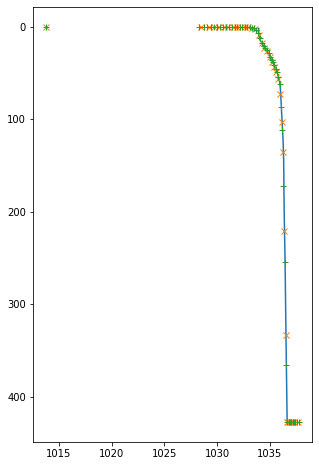

In [97]:
# Show the different grids
fig,ax = plt.subplots(figsize = (5,8))
ax.plot(prof_native.rhopot2,prof_intz_native.thkcello)
ax.plot(prof_rho2.rho2_l,prof_rho2.thkcello.cumsum(dim='rho2_l'),'x')
ax.plot(prof_rho2h.rho2h_l,prof_rho2h.thkcello.cumsum(dim='rho2h_l'),'+')
ax.invert_yaxis()

Text(0.5, 1.0, 'error')

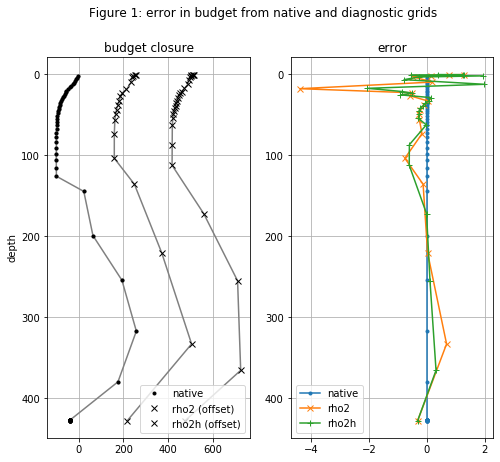

In [95]:
fig, ax = plt.subplots(figsize=(8,7),ncols=2)
fig.suptitle('Figure 1: error in budget from native and diagnostic grids')
# Plot the variable from the native grid, from the diagnostic grid,
# and from the diagnostic grid interpolated onto the native grid
var='tendsum'
max_native = np.max(np.fabs(prof_intz_native[var]))
max_rho2 = np.max(np.fabs(prof_intz_rho2[var]))
max_rho2h = np.max(np.fabs(prof_intz_rho2h[var]))
offset = np.max([max_native, max_rho2, max_rho2h])
ax[0].plot(prof_intz_native[var],prof_intz_native.thkcello,color='gray',marker='.')
ax[0].plot(prof_intz_rho2[var]+offset,prof_intz_rho2.thkcello,color='gray',marker='')
ax[0].plot(prof_intz_rho2h[var]+2*offset,prof_intz_rho2h.thkcello,color='gray',marker='')

var=tend
ax[0].plot(prof_intz_native[var],prof_intz_native.thkcello,color='black',marker='.',linestyle='',label='native')
ax[0].plot(prof_intz_rho2[var]+offset,prof_intz_rho2.thkcello,color='black',marker='x',linestyle='',label='rho2 (offset)')
ax[0].plot(prof_intz_rho2h[var]+2*offset,prof_intz_rho2h.thkcello,color='black',marker='x',linestyle='',label='rho2h (offset)')
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend()
ax[0].set_title('budget closure')

ax[0].set_ylabel('depth')

var='error'
ax[1].plot(prof_intz_native[var],prof_intz_native.thkcello,marker='.',label='native')
ax[1].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,marker='x',label='rho2')
ax[1].plot(prof_intz_rho2h[var],prof_intz_rho2h.thkcello,marker='+',label='rho2h')
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title(var)

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/core/computation.py:565: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


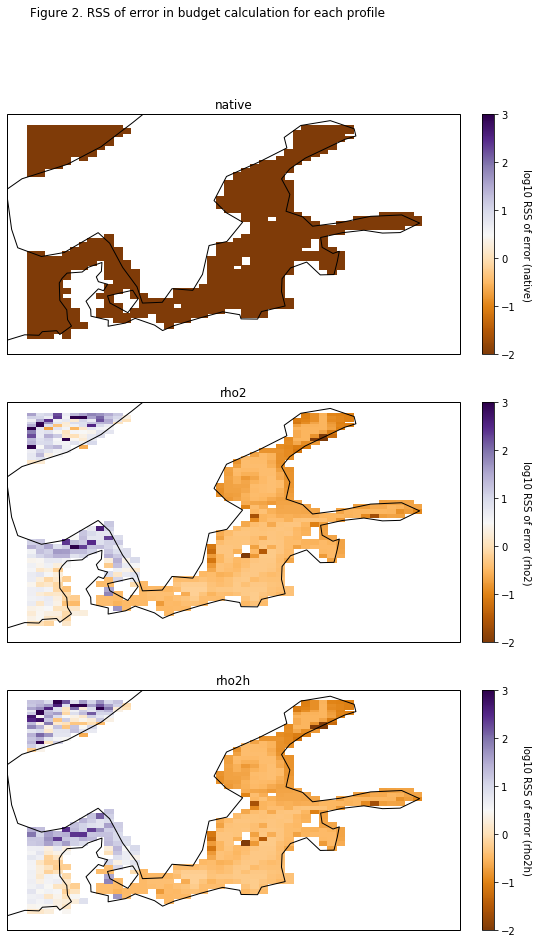

In [96]:
var = 'error'
ds_native_rms = xr.ufuncs.sqrt((ds_native[var]**2).sum(dim='zl'))
ds_rho2_rms = xr.ufuncs.sqrt((ds_rho2[var]**2).sum(dim='rho2_l'))
ds_rho2h_rms = xr.ufuncs.sqrt((ds_rho2h[var]**2).sum(dim='rho2h_l'))

fig,ax = plt.subplots(figsize=(10,15),nrows=3,subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Figure 2. RSS of error in budget calculation for each profile')

ax[0].coastlines()
ax[0].set_title('native')
im = ax[0].pcolormesh(
    ds_native_rms.xh,ds_native_rms.yh,np.log10(ds_native_rms),
    vmin=-2,vmax=3,cmap='PuOr')
cbar = plt.colorbar(im,ax=ax[0],fraction=0.025,pad=0.04);
cbar.set_label('log10 RSS of error (native)',rotation=270,labelpad=15)

ax[1].coastlines()
ax[1].set_title('rho2')
im = ax[1].pcolormesh(
    ds_rho2_rms.xh,ds_rho2_rms.yh,np.log10(ds_rho2_rms),
    vmin=-2,vmax=3,cmap='PuOr')
cbar = plt.colorbar(im,ax=ax[1],fraction=0.025,pad=0.04);
cbar.set_label('log10 RSS of error (rho2)',rotation=270,labelpad=15)

ax[2].coastlines()
ax[2].set_title('rho2h')
im = ax[2].pcolormesh(
    ds_rho2h_rms.xh,ds_rho2h_rms.yh,np.log10(ds_rho2h_rms),
    vmin=-2,vmax=3,cmap='PuOr')
cbar = plt.colorbar(im,ax=ax[2],fraction=0.025,pad=0.04);
cbar.set_label('log10 RSS of error (rho2h)',rotation=270,labelpad=15)